In [1]:
import numpy as np
import pandas as pd

import time
from datetime import datetime

import gensim
import matplotlib.pyplot as plt

import en_nlp_utils
import model_evaluation_utils

In [2]:
# Define default source path
SRC_PATH = "src/"

start_time = datetime.now()
print("Text processing started at {}".format(start_time))

Text processing started at 2024-06-26 22:29:42.280299


In [3]:
# Load dataset
df_review = pd.read_csv(SRC_PATH + "en_hotel_review.csv")

In [4]:
# Check NULL values
en_nlp_utils.check_null(df_review, "df_review")

# Remove rows when "review_cleaned_v2" is NULL
df_review = df_review.dropna(subset=["review_cleaned_v2"]).reset_index(drop=True)

df_review:
source                     0
hotel_id                   0
hotel_name                 0
country                    0
group_name                 0
room_type                  0
stay_length                0
stay_date                  0
review_score               0
review_score_category      0
sentiment                  0
review_date                0
review_title               1
review                     0
review_cleaned_v1          0
review_cleaned_v2        229
dtype: int64
Total rows in df_review: 39831 



## 1) Applying Stratified Sampling

In [5]:
# Function for stratified sampling
def stratified_sample(df, stratify_col, frac):
    return df.groupby(stratify_col, group_keys=False).apply(lambda x: x.sample(frac=frac))

# Convert "stay_date" and "review_date" columns as datetime data type
df_review["stay_date"] = pd.to_datetime(df_review["stay_date"], format="%d/%m/%Y")

# Stratified sampling based on year and sentiment
frac = 0.10  # Sampling ratio
sampled_2022 = stratified_sample(df_review[df_review["stay_date"].dt.year == 2022], "sentiment", frac)
sampled_2023 = stratified_sample(df_review[df_review["stay_date"].dt.year == 2023], "sentiment", frac)
sampled_2024 = stratified_sample(df_review[df_review["stay_date"].dt.year == 2024], "sentiment", frac)

# Merge the sampled data
sampled_data = pd.concat([sampled_2022, sampled_2023, sampled_2024])

In [6]:
# Count number of reviews based on year and sentiment
sampled_sentiment_count = sampled_data.groupby([sampled_data["sentiment"], sampled_data["stay_date"].dt.year]).size().reset_index(name="count")
sampled_sentiment_count2 = sampled_sentiment_count.pivot_table(index="stay_date", columns="sentiment", values="count", 
                                               aggfunc="sum", margins=True, margins_name="Total")
sampled_sentiment_count2.columns.name = None
sampled_sentiment_count2

,negative,positive,Total
stay_date,,,
2022,169,552,721
2023,535,2124,2659
2024,110,471,581
Total,814,3147,3961


## 2) Topic Modeling

### a) Helper functions

In [7]:
# Function to generate bow corpus
def generate_bow_corpus(df, target_text):
    
    documents = [en_nlp_utils.tokenize_sentence_to_words(cleaned_review) for cleaned_review in df[target_text]]
    
    bigram = gensim.models.Phrases(documents, min_count=20, threshold=20, delimiter="_") # higher threshold fewer phrases.
    bigram_model = gensim.models.phrases.Phraser(bigram)
    
    corpus_bigrams = [bigram_model[doc] for doc in documents]
    dictionary = gensim.corpora.Dictionary(corpus_bigrams)
    dictionary.filter_extremes(no_below=20, no_above=0.6)
    bow_corpus = [dictionary.doc2bow(text) for text in corpus_bigrams]
    
    return bow_corpus, corpus_bigrams, dictionary


# Function to calculate all models' coherence scores
def topic_model_coherence_plot(df, df_name, target_text, MODEL_NAMES, START_TOPIC_COUNT, END_TOPIC_COUNT):
    
    overall_coherence_df = pd.DataFrame() # Store each model's coherence scores
    model_topic_info = [] # Store each model's topic information
    
    bow_corpus, corpus_bigrams, dictionary = generate_bow_corpus(df, target_text)
    model_count = 0
    
    for MODEL_NAME in MODEL_NAMES:
        models, coherence_scores = en_nlp_utils.topic_model_coherence_generator(model_name=MODEL_NAME,
                                                                                corpus=bow_corpus,
                                                                                texts=corpus_bigrams,
                                                                                dictionary=dictionary,
                                                                                start_topic_count=START_TOPIC_COUNT,
                                                                                end_topic_count=END_TOPIC_COUNT,
                                                                                step=1,
                                                                                cpus=-1,
                                                                                print_topics=True)

        coherence_df = pd.DataFrame({"Model Name": MODEL_NAME, 
                                     "Number of Topics": range(START_TOPIC_COUNT, END_TOPIC_COUNT + 1, 1), 
                                     "Coherence Score": np.round(coherence_scores, 6),
                                     "df_name": df_name})
        coherence_df.sort_values(by=["Coherence Score"], ascending=False)
        print(coherence_df)
        
        overall_coherence_df = pd.concat([overall_coherence_df, coherence_df], axis=0)
        
        model_topics = []
        for model in models:
            num_topics = model.num_topics
            topics = [[(term, round(wt, 3)) for term, wt in model.show_topic(n, topn=10)] for n in range(num_topics)]
            
            # Determine the number of columns dynamically
            num_terms_per_topic = max(len(topic) for topic in topics)
            
            # Create a DataFrame for topics with dynamic columns and names
            topics_df = pd.DataFrame([[term if len(topic) > i else "" for i, (term, wt) in enumerate(topic)]
                                      for topic in topics],
                                     columns=[f"Term{i+1}" for i in range(num_terms_per_topic)],
                                     index=[f"Topic {t+1}" for t in range(num_topics)]).T
            
            model_topic_info.append({
                "Model Name": MODEL_NAME,
                "Number of Topics": num_topics,
                "Topics": topics_df.to_dict(orient="list"),  # Convert DataFrame to dictionary
                "df_name": df_name
            })
        
        x_ax = range(START_TOPIC_COUNT, END_TOPIC_COUNT + 1, 1)
        y_ax = coherence_scores
        plt.figure(num=model_count, figsize=(15, 12))
        plt.plot(x_ax, y_ax, c="r")
        plt.axhline(y=0.3, c="k", linestyle="--", linewidth=2)
        plt.axhline(y=0.4, c="k", linestyle="--", linewidth=2)
        plt.axhline(y=0.5, c="k", linestyle="--", linewidth=2)
        plt.rcParams["figure.facecolor"] = "white"
        xl = plt.xlabel("Number of Topics")
        yl = plt.ylabel("Coherence Score")

        model_count += 1

    plt.show()
    return overall_coherence_df, model_topic_info


# Function to print best model's topics
def print_best_model_topics(overall_coherence_best_df, model_topic_info_list):
    
    for index, row in overall_coherence_best_df.iterrows():
        model_name = row["Model Name"]
        num_topics = row["Number of Topics"]
        df_name = row["df_name"]
        
        print(f"\nDF NAME: {df_name}\nMODEL: {model_name} - NUMBER OF TOPICS: {num_topics}")
       
        # Find the corresponding model_topic_info
        for model_topic_info in model_topic_info_list:
            for model_info in model_topic_info:
                if (model_info["Model Name"] == model_name and
                    model_info["Number of Topics"] == num_topics and
                    model_info["df_name"] == df_name):
                    
                    topics = model_info["Topics"]
                    for topic_num, terms in topics.items():
                        print(f"\n{topic_num}: {', '.join(terms)}")
                        
                    print("\n----------\n")
                    break

### b) Topic Modeling

In [8]:
# Filter positive and negative reviews and save into different dataframe
df_pos = sampled_data[sampled_data["sentiment"] == "positive"].reset_index(drop=True)
df_neg = sampled_data[sampled_data["sentiment"] == "negative"].reset_index(drop=True)

In [9]:
MODEL_NAMES = ["LSI", "LDA"]
START_TOPIC_COUNT = 2
END_TOPIC_COUNT = 10

df_sets = [df_pos, df_neg]
df_names = ["df_pos", "df_neg"]


DF NAME: df_pos



  0%|                                                                                            | 0/9 [00:00<?, ?it/s]


MODEL: LSI - NUMBER OF TOPICS: 2


 11%|█████████▎                                                                          | 1/9 [00:47<06:18, 47.30s/it]

Topic #1:
0.400*"good" + 0.378*"staff" + 0.284*"clean" + 0.177*"great" + 0.165*"nice" + 0.146*"friendly" + 0.145*"small" + 0.141*"bed" + 0.140*"also" + 0.138*"check" + 0.115*"food" + 0.113*"helpful" + 0.108*"breakfast" + 0.105*"area" + 0.103*"meet" + 0.102*"near" + 0.101*"need" + 0.100*"well" + 0.100*"water" + 0.094*"book"

Topic #2:
-0.857*"good" + 0.300*"staff" + 0.178*"great" + 0.162*"check" + 0.092*"book" + 0.088*"friendly" + 0.084*"helpful" + 0.075*"could" + 0.070*"clean" + 0.067*"nice" + 0.063*"also" + 0.063*"make" + 0.055*"god" + 0.054*"reception" + 0.052*"pm" + 0.048*"need" + 0.045*"wait" + 0.044*"another" + -0.044*"food" + 0.044*"bed"

--------------------------------------------------

MODEL: LSI - NUMBER OF TOPICS: 3


 22%|██████████████████▋                                                                 | 2/9 [01:36<05:37, 48.24s/it]

Topic #1:
0.400*"good" + 0.380*"staff" + 0.284*"clean" + 0.178*"great" + 0.165*"nice" + 0.147*"friendly" + 0.145*"small" + 0.140*"bed" + 0.139*"also" + 0.137*"check" + 0.115*"food" + 0.114*"helpful" + 0.108*"breakfast" + 0.105*"area" + 0.103*"meet" + 0.102*"near" + 0.101*"need" + 0.100*"well" + 0.099*"water" + 0.094*"book"

Topic #2:
-0.845*"good" + 0.345*"staff" + 0.186*"great" + 0.151*"check" + 0.107*"friendly" + 0.095*"helpful" + 0.081*"book" + 0.071*"could" + 0.071*"nice" + 0.061*"make" + 0.054*"also" + 0.053*"reception" + 0.051*"clean" + 0.051*"pm" + 0.048*"god" + -0.046*"food" + 0.045*"wait" + 0.044*"need" + 0.043*"another" + 0.042*"tell"

Topic #3:
-0.616*"staff" + -0.256*"friendly" + 0.200*"book" + 0.196*"god" + 0.193*"bed" + -0.184*"good" + 0.154*"small" + -0.153*"helpful" + 0.148*"clean" + 0.144*"check" + 0.130*"water" + 0.130*"also" + 0.104*"use" + 0.103*"could" + 0.101*"bathroom" + 0.101*"shower" + -0.099*"nice" + -0.098*"great" + 0.096*"like" + 0.096*"two"

---------------

 33%|████████████████████████████                                                        | 3/9 [02:25<04:52, 48.72s/it]

Topic #1:
0.400*"good" + 0.381*"staff" + 0.285*"clean" + 0.178*"great" + 0.165*"nice" + 0.147*"friendly" + 0.145*"small" + 0.140*"bed" + 0.139*"also" + 0.136*"check" + 0.115*"food" + 0.114*"helpful" + 0.108*"breakfast" + 0.105*"area" + 0.103*"near" + 0.103*"meet" + 0.101*"need" + 0.100*"well" + 0.099*"water" + 0.093*"book"

Topic #2:
-0.859*"good" + 0.315*"staff" + 0.184*"great" + 0.147*"check" + 0.098*"friendly" + 0.088*"helpful" + 0.074*"book" + 0.074*"nice" + 0.070*"clean" + 0.069*"could" + 0.064*"also" + 0.061*"make" + 0.047*"reception" + 0.046*"pm" + 0.044*"need" + -0.042*"food" + 0.040*"bed" + 0.039*"wait" + 0.039*"another" + 0.038*"god"

Topic #3:
-0.644*"staff" + -0.251*"friendly" + 0.214*"bed" + 0.207*"clean" + -0.188*"good" + 0.187*"small" + 0.167*"water" + 0.167*"also" + -0.164*"helpful" + 0.125*"shower" + 0.117*"bathroom" + 0.107*"like" + 0.105*"check" + 0.100*"towel" + 0.100*"use" + -0.097*"great" + 0.096*"provide" + 0.092*"book" + 0.082*"toilet" + 0.075*"near"

Topic #4:


 44%|█████████████████████████████████████▎                                              | 4/9 [03:15<04:05, 49.14s/it]

Topic #1:
0.400*"good" + 0.379*"staff" + 0.285*"clean" + 0.180*"great" + 0.166*"nice" + 0.147*"friendly" + 0.144*"small" + 0.139*"bed" + 0.139*"also" + 0.136*"check" + 0.116*"food" + 0.114*"helpful" + 0.108*"breakfast" + 0.105*"area" + 0.104*"near" + 0.103*"meet" + 0.101*"need" + 0.100*"well" + 0.099*"water" + 0.094*"book"

Topic #2:
-0.857*"good" + 0.321*"staff" + 0.178*"great" + 0.148*"check" + 0.100*"friendly" + 0.090*"clean" + 0.090*"helpful" + 0.075*"nice" + 0.074*"book" + 0.067*"could" + 0.060*"also" + 0.060*"make" + -0.047*"food" + 0.047*"reception" + 0.046*"pm" + 0.043*"need" + 0.040*"another" + 0.039*"wait" + 0.039*"bed" + 0.038*"god"

Topic #3:
-0.672*"staff" + -0.249*"friendly" + 0.248*"clean" + -0.203*"good" + 0.183*"bed" + 0.174*"also" + -0.166*"helpful" + 0.165*"small" + 0.150*"water" + 0.115*"near" + 0.105*"shower" + 0.101*"bathroom" + 0.094*"like" + 0.090*"towel" + 0.087*"provide" + 0.087*"use" + 0.079*"book" + 0.075*"meet" + 0.074*"toilet" + 0.072*"walk"

Topic #4:
-0.

 56%|██████████████████████████████████████████████▋                                     | 5/9 [04:05<03:18, 49.56s/it]

Topic #1:
0.400*"good" + 0.380*"staff" + 0.286*"clean" + 0.178*"great" + 0.166*"nice" + 0.147*"friendly" + 0.144*"small" + 0.139*"bed" + 0.139*"also" + 0.136*"check" + 0.115*"food" + 0.114*"helpful" + 0.108*"breakfast" + 0.105*"area" + 0.104*"near" + 0.103*"meet" + 0.101*"need" + 0.100*"well" + 0.099*"water" + 0.094*"book"

Topic #2:
-0.857*"good" + 0.320*"staff" + 0.181*"great" + 0.148*"check" + 0.100*"friendly" + 0.089*"helpful" + 0.082*"clean" + 0.079*"nice" + 0.074*"book" + 0.068*"could" + 0.060*"also" + 0.060*"make" + 0.047*"reception" + 0.046*"pm" + -0.045*"food" + 0.043*"need" + 0.040*"another" + 0.039*"wait" + 0.038*"bed" + 0.038*"god"

Topic #3:
-0.670*"staff" + 0.264*"clean" + -0.248*"friendly" + -0.201*"good" + 0.185*"bed" + 0.173*"also" + -0.165*"helpful" + 0.162*"small" + 0.150*"water" + 0.110*"near" + 0.105*"shower" + 0.101*"bathroom" + 0.093*"like" + 0.091*"towel" + 0.088*"provide" + 0.087*"use" + 0.078*"book" + 0.074*"toilet" + 0.072*"meet" + 0.070*"walk"

Topic #4:
-0.

 67%|████████████████████████████████████████████████████████                            | 6/9 [05:02<02:36, 52.21s/it]

Topic #1:
0.400*"good" + 0.380*"staff" + 0.285*"clean" + 0.178*"great" + 0.165*"nice" + 0.147*"friendly" + 0.145*"small" + 0.140*"bed" + 0.139*"also" + 0.135*"check" + 0.115*"food" + 0.114*"helpful" + 0.108*"breakfast" + 0.105*"area" + 0.103*"near" + 0.103*"meet" + 0.101*"need" + 0.100*"well" + 0.099*"water" + 0.094*"book"

Topic #2:
-0.858*"good" + 0.319*"staff" + 0.180*"great" + 0.146*"check" + 0.100*"friendly" + 0.090*"helpful" + 0.081*"clean" + 0.078*"nice" + 0.075*"book" + 0.068*"could" + 0.061*"also" + 0.060*"make" + 0.047*"reception" + 0.046*"pm" + -0.045*"food" + 0.043*"need" + 0.040*"another" + 0.039*"bed" + 0.039*"wait" + 0.038*"god"

Topic #3:
-0.658*"staff" + -0.246*"friendly" + 0.232*"clean" + 0.204*"bed" + -0.202*"good" + 0.178*"also" + 0.176*"small" + -0.161*"helpful" + 0.157*"water" + 0.111*"shower" + 0.109*"bathroom" + 0.103*"like" + 0.101*"near" + 0.095*"towel" + 0.093*"use" + 0.091*"provide" + 0.091*"book" + 0.078*"toilet" + 0.068*"walk" + 0.067*"meet"

Topic #4:
-0.

 78%|█████████████████████████████████████████████████████████████████▎                  | 7/9 [05:57<01:45, 52.84s/it]

Topic #1:
0.400*"good" + 0.380*"staff" + 0.285*"clean" + 0.178*"great" + 0.166*"nice" + 0.147*"friendly" + 0.145*"small" + 0.140*"bed" + 0.139*"also" + 0.135*"check" + 0.115*"food" + 0.114*"helpful" + 0.108*"breakfast" + 0.105*"area" + 0.103*"near" + 0.103*"meet" + 0.101*"need" + 0.100*"well" + 0.099*"water" + 0.094*"book"

Topic #2:
-0.859*"good" + 0.317*"staff" + 0.179*"great" + 0.146*"check" + 0.099*"friendly" + 0.090*"helpful" + 0.079*"clean" + 0.075*"nice" + 0.074*"book" + 0.068*"could" + 0.063*"also" + 0.061*"make" + 0.047*"reception" + 0.046*"pm" + 0.045*"need" + -0.044*"food" + 0.040*"another" + 0.039*"wait" + 0.038*"bed" + 0.038*"even"

Topic #3:
-0.661*"staff" + -0.246*"friendly" + 0.223*"clean" + 0.202*"bed" + -0.200*"good" + 0.179*"also" + 0.175*"small" + -0.161*"helpful" + 0.155*"water" + 0.110*"shower" + 0.108*"near" + 0.106*"bathroom" + 0.103*"like" + 0.093*"use" + 0.093*"towel" + 0.090*"provide" + 0.089*"book" + 0.079*"toilet" + 0.073*"meet" + 0.072*"walk"

Topic #4:
-0

 89%|██████████████████████████████████████████████████████████████████████████▋         | 8/9 [06:51<00:53, 53.34s/it]

Topic #1:
0.400*"good" + 0.380*"staff" + 0.285*"clean" + 0.178*"great" + 0.165*"nice" + 0.147*"friendly" + 0.145*"small" + 0.140*"bed" + 0.139*"also" + 0.136*"check" + 0.115*"food" + 0.114*"helpful" + 0.108*"breakfast" + 0.105*"area" + 0.103*"near" + 0.102*"meet" + 0.101*"need" + 0.100*"well" + 0.099*"water" + 0.094*"book"

Topic #2:
-0.859*"good" + 0.318*"staff" + 0.179*"great" + 0.146*"check" + 0.101*"friendly" + 0.091*"helpful" + 0.079*"clean" + 0.073*"book" + 0.073*"nice" + 0.068*"could" + 0.061*"also" + 0.061*"make" + 0.047*"reception" + 0.046*"pm" + -0.044*"food" + 0.044*"need" + 0.039*"another" + 0.039*"wait" + 0.038*"even" + 0.038*"bed"

Topic #3:
-0.662*"staff" + -0.250*"friendly" + 0.216*"clean" + 0.201*"bed" + -0.198*"good" + 0.183*"also" + 0.169*"small" + -0.163*"helpful" + 0.155*"water" + 0.110*"shower" + 0.105*"near" + 0.105*"bathroom" + 0.104*"like" + 0.094*"use" + 0.093*"towel" + 0.091*"book" + 0.091*"provide" + 0.077*"toilet" + 0.071*"walk" + 0.069*"meet"

Topic #4:
-0

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [07:45<00:00, 51.73s/it]


Topic #1:
0.400*"good" + 0.380*"staff" + 0.285*"clean" + 0.178*"great" + 0.165*"nice" + 0.147*"friendly" + 0.145*"small" + 0.140*"bed" + 0.139*"also" + 0.137*"check" + 0.115*"food" + 0.114*"helpful" + 0.108*"breakfast" + 0.105*"area" + 0.103*"near" + 0.102*"meet" + 0.101*"need" + 0.100*"well" + 0.099*"water" + 0.094*"book"

Topic #2:
-0.859*"good" + 0.317*"staff" + 0.180*"great" + 0.151*"check" + 0.101*"friendly" + 0.091*"helpful" + 0.078*"clean" + 0.074*"book" + 0.073*"nice" + 0.067*"could" + 0.061*"make" + 0.060*"also" + 0.047*"pm" + -0.046*"food" + 0.046*"reception" + 0.043*"need" + 0.042*"bed" + 0.039*"even" + 0.039*"wait" + 0.039*"another"

Topic #3:
-0.664*"staff" + -0.255*"friendly" + 0.218*"clean" + 0.206*"bed" + -0.197*"good" + 0.172*"also" + 0.171*"small" + -0.165*"helpful" + 0.147*"water" + 0.107*"shower" + 0.103*"like" + 0.101*"bathroom" + 0.093*"book" + 0.092*"use" + 0.089*"towel" + 0.089*"near" + 0.087*"provide" + 0.079*"walk" + 0.078*"toilet" + 0.076*"check"

Topic #4:
-

  0%|                                                                                            | 0/9 [00:00<?, ?it/s]


MODEL: LDA - NUMBER OF TOPICS: 2


 11%|█████████▎                                                                          | 1/9 [00:05<00:45,  5.68s/it]

Topic #1:
0.041*"good" + 0.030*"clean" + 0.030*"staff" + 0.023*"nice" + 0.014*"friendly" + 0.013*"small" + 0.012*"great" + 0.011*"bed" + 0.011*"like" + 0.010*"food" + 0.010*"helpful" + 0.009*"need" + 0.008*"really" + 0.008*"close" + 0.008*"water" + 0.008*"bathroom" + 0.008*"shower" + 0.008*"bit" + 0.008*"area" + 0.007*"overall"

Topic #2:
0.028*"staff" + 0.025*"good" + 0.021*"great" + 0.018*"near" + 0.014*"meet" + 0.014*"check" + 0.014*"clean" + 0.012*"also" + 0.011*"breakfast" + 0.010*"service" + 0.010*"singapore" + 0.010*"small" + 0.009*"friendly" + 0.009*"pool" + 0.008*"restaurant" + 0.008*"many" + 0.008*"walk" + 0.008*"well" + 0.008*"nice" + 0.007*"comfortable"

--------------------------------------------------

MODEL: LDA - NUMBER OF TOPICS: 3


 22%|██████████████████▋                                                                 | 2/9 [00:11<00:38,  5.52s/it]

Topic #1:
0.029*"good" + 0.026*"staff" + 0.022*"nice" + 0.019*"near" + 0.015*"restaurant" + 0.014*"meet" + 0.014*"pool" + 0.014*"small" + 0.013*"clean" + 0.013*"walk" + 0.011*"also" + 0.011*"food" + 0.011*"close" + 0.010*"convenient" + 0.010*"bit" + 0.009*"meet_station" + 0.009*"love" + 0.009*"walk_distance" + 0.008*"station" + 0.008*"breakfast"

Topic #2:
0.053*"good" + 0.035*"staff" + 0.031*"clean" + 0.018*"friendly" + 0.014*"nice" + 0.013*"food" + 0.013*"check" + 0.013*"meet" + 0.011*"near" + 0.011*"need" + 0.010*"helpful" + 0.010*"area" + 0.010*"service" + 0.009*"breakfast" + 0.009*"bed" + 0.009*"great" + 0.008*"also" + 0.008*"comfortable" + 0.008*"small" + 0.007*"facility"

Topic #3:
0.031*"great" + 0.024*"staff" + 0.020*"clean" + 0.014*"good" + 0.014*"nice" + 0.014*"small" + 0.012*"bed" + 0.010*"water" + 0.010*"book" + 0.010*"like" + 0.009*"shower" + 0.009*"well" + 0.009*"could" + 0.008*"friendly" + 0.008*"breakfast" + 0.008*"bathroom" + 0.008*"really" + 0.008*"check" + 0.007*"ne

 33%|████████████████████████████                                                        | 3/9 [00:16<00:31,  5.31s/it]

Topic #1:
0.028*"good" + 0.025*"near" + 0.024*"staff" + 0.024*"clean" + 0.019*"nice" + 0.018*"check" + 0.016*"food" + 0.015*"great" + 0.014*"small" + 0.013*"bed" + 0.013*"meet" + 0.010*"like" + 0.010*"well" + 0.010*"restaurant" + 0.009*"close" + 0.009*"comfortable" + 0.009*"helpful" + 0.009*"everything" + 0.008*"singapore" + 0.008*"many"

Topic #2:
0.053*"good" + 0.026*"clean" + 0.024*"nice" + 0.017*"staff" + 0.014*"small" + 0.012*"water" + 0.011*"area" + 0.011*"food" + 0.011*"great" + 0.010*"also" + 0.010*"pool" + 0.009*"breakfast" + 0.009*"convenient" + 0.009*"spacious" + 0.008*"facility" + 0.008*"overall" + 0.008*"love" + 0.008*"near" + 0.007*"provide" + 0.007*"service"

Topic #3:
0.021*"good" + 0.020*"staff" + 0.019*"small" + 0.018*"bathroom" + 0.016*"need" + 0.015*"clean" + 0.014*"bed" + 0.013*"breakfast" + 0.011*"really" + 0.010*"station" + 0.010*"like" + 0.010*"well" + 0.009*"next" + 0.009*"shower" + 0.008*"near" + 0.008*"bit" + 0.008*"book" + 0.008*"also" + 0.008*"could" + 0.00

 44%|█████████████████████████████████████▎                                              | 4/9 [00:20<00:25,  5.13s/it]

Topic #1:
0.026*"staff" + 0.024*"good" + 0.018*"near" + 0.018*"clean" + 0.013*"price" + 0.011*"excellent" + 0.011*"overall" + 0.010*"nice" + 0.009*"station" + 0.009*"quite" + 0.009*"meet" + 0.009*"check" + 0.009*"really" + 0.009*"service" + 0.009*"small" + 0.009*"food" + 0.009*"walk" + 0.008*"bus" + 0.008*"helpful" + 0.007*"recommend"

Topic #2:
0.038*"staff" + 0.036*"great" + 0.024*"good" + 0.022*"friendly" + 0.021*"meet" + 0.020*"clean" + 0.019*"small" + 0.017*"near" + 0.016*"helpful" + 0.015*"restaurant" + 0.013*"close" + 0.012*"convenient" + 0.011*"also" + 0.011*"walk" + 0.011*"food" + 0.010*"need" + 0.010*"nice" + 0.009*"many" + 0.008*"meet_station" + 0.008*"facility"

Topic #3:
0.023*"great" + 0.019*"breakfast" + 0.019*"staff" + 0.019*"view" + 0.017*"book" + 0.016*"small" + 0.015*"clean" + 0.013*"pool" + 0.013*"love" + 0.012*"amazing" + 0.010*"ok" + 0.010*"good" + 0.010*"nice" + 0.010*"bed" + 0.009*"next" + 0.009*"budget" + 0.009*"recommend" + 0.009*"size" + 0.009*"meet_station" 

 56%|██████████████████████████████████████████████▋                                     | 5/9 [00:25<00:20,  5.04s/it]

Topic #1:
0.037*"good" + 0.022*"staff" + 0.021*"nice" + 0.021*"clean" + 0.017*"food" + 0.013*"facility" + 0.013*"area" + 0.012*"pool" + 0.011*"find" + 0.011*"great" + 0.011*"check" + 0.010*"well" + 0.010*"service" + 0.009*"need" + 0.009*"singapore" + 0.009*"restaurant" + 0.008*"meet" + 0.008*"overall" + 0.008*"experience" + 0.007*"far"

Topic #2:
0.023*"bed" + 0.023*"staff" + 0.016*"small" + 0.013*"need" + 0.012*"quite" + 0.012*"nice" + 0.012*"ok" + 0.011*"breakfast" + 0.011*"next" + 0.011*"large" + 0.011*"enough" + 0.011*"area" + 0.010*"like" + 0.010*"clean" + 0.009*"luggage" + 0.009*"shower" + 0.009*"pool" + 0.009*"walk_distance" + 0.008*"near" + 0.008*"change"

Topic #3:
0.031*"clean" + 0.029*"staff" + 0.026*"great" + 0.021*"meet" + 0.019*"close" + 0.019*"small" + 0.018*"check" + 0.015*"good" + 0.013*"restaurant" + 0.011*"nice" + 0.010*"walk" + 0.010*"nearby" + 0.010*"near" + 0.009*"also" + 0.009*"convenient" + 0.009*"even" + 0.009*"come" + 0.008*"around" + 0.008*"friendly" + 0.007*

 67%|████████████████████████████████████████████████████████                            | 6/9 [00:30<00:14,  4.93s/it]

Topic #1:
0.073*"staff" + 0.029*"friendly" + 0.022*"clean" + 0.021*"helpful" + 0.016*"nice" + 0.015*"great" + 0.015*"pool" + 0.012*"excellent" + 0.012*"breakfast" + 0.011*"service" + 0.010*"food" + 0.010*"good" + 0.010*"really" + 0.009*"make" + 0.009*"also" + 0.009*"need" + 0.008*"book" + 0.008*"area" + 0.007*"accommodation" + 0.007*"amazing"

Topic #2:
0.042*"good" + 0.026*"staff" + 0.026*"clean" + 0.023*"near" + 0.019*"nice" + 0.013*"bed" + 0.013*"meet" + 0.013*"food" + 0.012*"meet_station" + 0.012*"great" + 0.012*"friendly" + 0.010*"recommend" + 0.010*"restaurant" + 0.010*"small" + 0.009*"close" + 0.009*"like" + 0.009*"walk" + 0.009*"area" + 0.009*"helpful" + 0.008*"station"

Topic #3:
0.087*"good" + 0.026*"staff" + 0.023*"clean" + 0.015*"check" + 0.013*"nice" + 0.012*"service" + 0.012*"come" + 0.011*"water" + 0.011*"friendly" + 0.011*"comfortable" + 0.010*"overall" + 0.009*"area" + 0.008*"singapore" + 0.008*"breakfast" + 0.008*"need" + 0.008*"bed" + 0.008*"close" + 0.007*"meet" + 0

 78%|█████████████████████████████████████████████████████████████████▎                  | 7/9 [00:35<00:09,  4.86s/it]

Topic #1:
0.075*"good" + 0.026*"near" + 0.022*"clean" + 0.020*"meet" + 0.019*"staff" + 0.016*"like" + 0.015*"nice" + 0.013*"meet_station" + 0.013*"spacious" + 0.013*"small" + 0.013*"food" + 0.012*"service" + 0.012*"well" + 0.009*"also" + 0.009*"value_money" + 0.009*"nearby" + 0.008*"breakfast" + 0.008*"bathroom" + 0.008*"friendly" + 0.008*"close"

Topic #2:
0.037*"staff" + 0.028*"clean" + 0.025*"bed" + 0.024*"good" + 0.015*"shower" + 0.014*"helpful" + 0.014*"small" + 0.014*"nice" + 0.013*"close" + 0.013*"well" + 0.013*"friendly" + 0.012*"comfortable" + 0.011*"really" + 0.010*"book" + 0.010*"even" + 0.009*"need" + 0.009*"meet" + 0.008*"bathroom" + 0.008*"work" + 0.008*"sleep"

Topic #3:
0.072*"staff" + 0.031*"friendly" + 0.024*"good" + 0.017*"check" + 0.017*"clean" + 0.015*"great" + 0.015*"service" + 0.013*"make" + 0.012*"helpful" + 0.011*"facility" + 0.011*"singapore" + 0.010*"overall" + 0.009*"city" + 0.009*"could" + 0.008*"quite" + 0.008*"pm" + 0.008*"need" + 0.008*"old" + 0.008*"sti

 89%|██████████████████████████████████████████████████████████████████████████▋         | 8/9 [00:39<00:04,  4.78s/it]

Topic #1:
0.065*"good" + 0.026*"staff" + 0.022*"clean" + 0.015*"food" + 0.013*"friendly" + 0.011*"helpful" + 0.010*"check" + 0.010*"bed" + 0.009*"also" + 0.009*"meet" + 0.009*"next" + 0.009*"small" + 0.009*"breakfast" + 0.008*"water" + 0.008*"near" + 0.008*"many" + 0.008*"great" + 0.008*"comfortable" + 0.008*"even" + 0.007*"quite"

Topic #2:
0.042*"staff" + 0.040*"near" + 0.033*"good" + 0.024*"nice" + 0.020*"meet" + 0.019*"clean" + 0.018*"small" + 0.015*"convenient" + 0.014*"bus_stop" + 0.014*"area" + 0.014*"pool" + 0.014*"locate" + 0.012*"view" + 0.012*"friendly" + 0.011*"quite" + 0.011*"guest" + 0.010*"helpful" + 0.010*"overall" + 0.009*"food" + 0.009*"well"

Topic #3:
0.033*"breakfast" + 0.030*"good" + 0.030*"great" + 0.021*"clean" + 0.020*"come" + 0.019*"facility" + 0.018*"pool" + 0.017*"really" + 0.017*"service" + 0.015*"spacious" + 0.013*"enjoy" + 0.012*"ok" + 0.012*"bed" + 0.011*"food" + 0.011*"staff" + 0.011*"bit" + 0.011*"decent" + 0.010*"meet" + 0.009*"nothing" + 0.009*"littl

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:44<00:00,  4.96s/it]

Topic #1:
0.069*"good" + 0.018*"near" + 0.016*"meet" + 0.016*"food" + 0.016*"staff" + 0.012*"service" + 0.011*"also" + 0.011*"bed" + 0.010*"budget" + 0.010*"come" + 0.009*"breakfast" + 0.009*"need" + 0.009*"accessible" + 0.009*"area" + 0.009*"available" + 0.008*"singapore" + 0.008*"sleep" + 0.008*"price" + 0.008*"check" + 0.008*"clean"

Topic #2:
0.038*"staff" + 0.029*"good" + 0.025*"great" + 0.021*"water" + 0.016*"shower" + 0.014*"bed" + 0.014*"clean" + 0.013*"friendly" + 0.013*"nice" + 0.012*"also" + 0.012*"comfortable" + 0.011*"helpful" + 0.011*"work" + 0.010*"experience" + 0.010*"check" + 0.009*"well" + 0.009*"near" + 0.009*"even" + 0.009*"toilet" + 0.009*"small"

Topic #3:
0.068*"good" + 0.029*"staff" + 0.017*"like" + 0.015*"walk" + 0.015*"breakfast" + 0.014*"area" + 0.012*"pool" + 0.011*"nice" + 0.011*"small" + 0.011*"shop" + 0.011*"quite" + 0.011*"swim_pool" + 0.010*"around" + 0.010*"could" + 0.010*"really" + 0.009*"locate" + 0.009*"check" + 0.009*"meet" + 0.009*"food" + 0.009*"

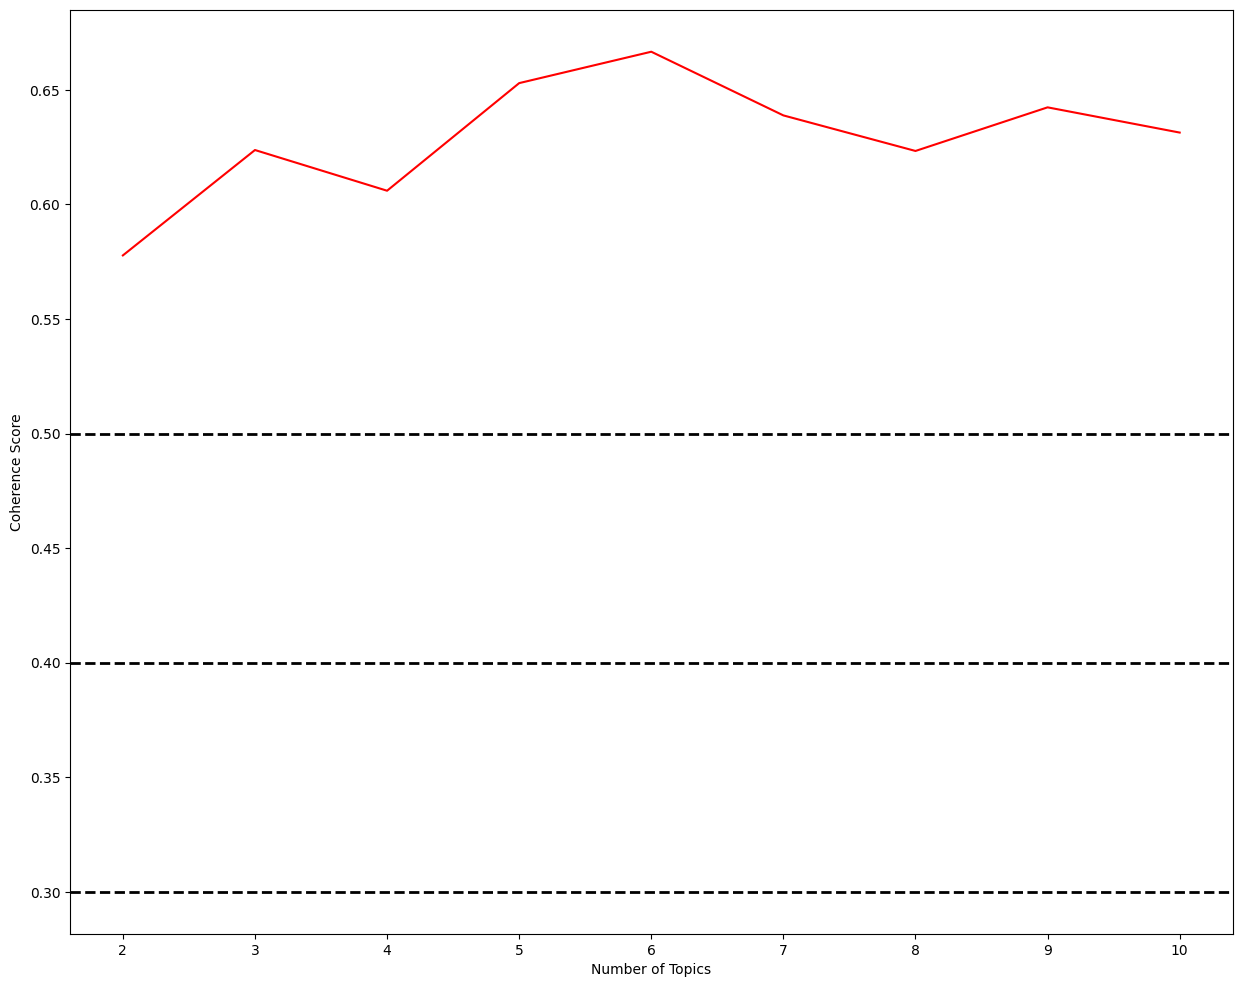

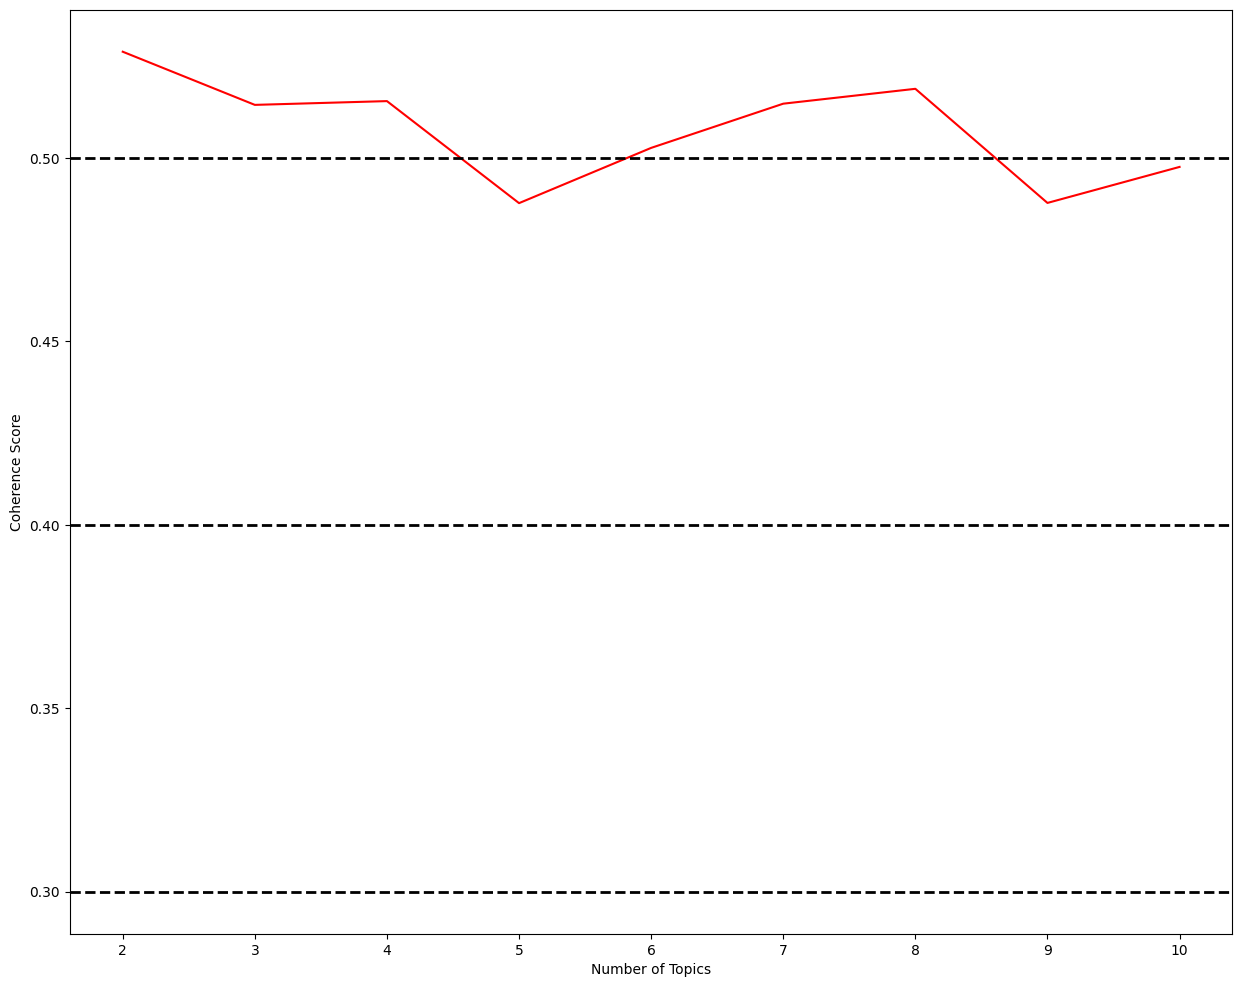


DF NAME: df_neg



  0%|                                                                                            | 0/9 [00:00<?, ?it/s]


MODEL: LSI - NUMBER OF TOPICS: 2


 11%|█████████▎                                                                          | 1/9 [00:06<00:55,  6.99s/it]

Topic #1:
0.345*"staff" + 0.251*"clean" + 0.251*"check" + 0.208*"small" + 0.205*"good" + 0.189*"even" + 0.180*"breakfast" + 0.164*"could" + 0.163*"bathroom" + 0.160*"toilet" + 0.158*"bed" + 0.155*"bad" + 0.148*"smell" + 0.130*"well" + 0.127*"book" + 0.125*"reception" + 0.124*"also" + 0.123*"service" + 0.118*"water" + 0.103*"need"

Topic #2:
-0.500*"staff" + 0.491*"small" + -0.384*"check" + 0.285*"clean" + 0.176*"bathroom" + 0.166*"toilet" + 0.125*"bed" + 0.118*"bit" + -0.118*"reception" + 0.110*"shower" + 0.094*"floor" + 0.093*"space" + -0.091*"hour" + -0.087*"experience" + 0.086*"like" + 0.085*"also" + -0.083*"ask" + 0.083*"look" + 0.079*"window" + 0.077*"breakfast"

--------------------------------------------------

MODEL: LSI - NUMBER OF TOPICS: 3


 22%|██████████████████▋                                                                 | 2/9 [00:15<00:54,  7.77s/it]

Topic #1:
0.345*"staff" + 0.251*"clean" + 0.251*"check" + 0.208*"small" + 0.205*"good" + 0.189*"even" + 0.180*"breakfast" + 0.164*"could" + 0.163*"bathroom" + 0.160*"toilet" + 0.158*"bed" + 0.155*"bad" + 0.148*"smell" + 0.130*"well" + 0.127*"book" + 0.125*"reception" + 0.124*"also" + 0.123*"service" + 0.118*"water" + 0.103*"need"

Topic #2:
-0.500*"staff" + 0.491*"small" + -0.384*"check" + 0.285*"clean" + 0.176*"bathroom" + 0.166*"toilet" + 0.125*"bed" + 0.118*"bit" + -0.118*"reception" + 0.110*"shower" + 0.094*"floor" + 0.093*"space" + -0.091*"hour" + -0.087*"experience" + 0.086*"like" + 0.085*"also" + -0.083*"ask" + 0.083*"look" + 0.079*"window" + 0.077*"breakfast"

Topic #3:
0.629*"breakfast" + -0.506*"clean" + 0.235*"small" + -0.153*"staff" + 0.152*"book" + 0.147*"could" + -0.142*"toilet" + 0.128*"restaurant" + 0.118*"bad" + 0.110*"pay" + -0.108*"water" + -0.106*"smell" + -0.104*"bathroom" + -0.096*"come" + -0.089*"back" + 0.087*"take" + 0.087*"keep" + -0.082*"bed" + 0.079*"bit" + 

 33%|████████████████████████████                                                        | 3/9 [00:24<00:49,  8.22s/it]

Topic #1:
0.345*"staff" + 0.251*"clean" + 0.251*"check" + 0.208*"small" + 0.205*"good" + 0.189*"even" + 0.180*"breakfast" + 0.164*"could" + 0.163*"bathroom" + 0.160*"toilet" + 0.158*"bed" + 0.155*"bad" + 0.148*"smell" + 0.130*"well" + 0.127*"book" + 0.125*"reception" + 0.124*"also" + 0.123*"service" + 0.118*"water" + 0.103*"need"

Topic #2:
-0.500*"staff" + 0.491*"small" + -0.384*"check" + 0.285*"clean" + 0.176*"bathroom" + 0.166*"toilet" + 0.125*"bed" + 0.118*"bit" + -0.118*"reception" + 0.110*"shower" + 0.094*"floor" + 0.093*"space" + -0.091*"hour" + -0.087*"experience" + 0.086*"like" + 0.085*"also" + -0.083*"ask" + 0.083*"look" + 0.079*"window" + 0.077*"breakfast"

Topic #3:
-0.629*"breakfast" + 0.506*"clean" + -0.235*"small" + 0.153*"staff" + -0.152*"book" + -0.147*"could" + 0.142*"toilet" + -0.128*"restaurant" + -0.118*"bad" + -0.110*"pay" + 0.108*"water" + 0.106*"smell" + 0.104*"bathroom" + 0.096*"come" + 0.089*"back" + -0.087*"take" + -0.087*"keep" + 0.082*"bed" + -0.079*"bit" +

 44%|█████████████████████████████████████▎                                              | 4/9 [00:31<00:40,  8.09s/it]

Topic #1:
0.345*"staff" + 0.251*"clean" + 0.251*"check" + 0.208*"small" + 0.205*"good" + 0.189*"even" + 0.180*"breakfast" + 0.164*"could" + 0.163*"bathroom" + 0.160*"toilet" + 0.158*"bed" + 0.155*"bad" + 0.148*"smell" + 0.130*"well" + 0.127*"book" + 0.125*"reception" + 0.124*"also" + 0.123*"service" + 0.118*"water" + 0.103*"need"

Topic #2:
0.500*"staff" + -0.491*"small" + 0.384*"check" + -0.285*"clean" + -0.176*"bathroom" + -0.166*"toilet" + -0.125*"bed" + -0.118*"bit" + 0.118*"reception" + -0.110*"shower" + -0.094*"floor" + -0.093*"space" + 0.091*"hour" + 0.087*"experience" + -0.086*"like" + -0.085*"also" + 0.083*"ask" + -0.083*"look" + -0.079*"window" + -0.077*"breakfast"

Topic #3:
0.629*"breakfast" + -0.506*"clean" + 0.235*"small" + -0.153*"staff" + 0.152*"book" + 0.147*"could" + -0.142*"toilet" + 0.128*"restaurant" + 0.118*"bad" + 0.110*"pay" + -0.108*"water" + -0.106*"smell" + -0.104*"bathroom" + -0.096*"come" + -0.089*"back" + 0.087*"take" + 0.087*"keep" + -0.082*"bed" + 0.079*

 56%|██████████████████████████████████████████████▋                                     | 5/9 [00:39<00:32,  8.06s/it]

Topic #1:
0.345*"staff" + 0.251*"clean" + 0.251*"check" + 0.208*"small" + 0.205*"good" + 0.189*"even" + 0.180*"breakfast" + 0.164*"could" + 0.163*"bathroom" + 0.160*"toilet" + 0.158*"bed" + 0.155*"bad" + 0.148*"smell" + 0.130*"well" + 0.127*"book" + 0.125*"reception" + 0.124*"also" + 0.123*"service" + 0.118*"water" + 0.103*"need"

Topic #2:
-0.500*"staff" + 0.491*"small" + -0.384*"check" + 0.285*"clean" + 0.176*"bathroom" + 0.166*"toilet" + 0.125*"bed" + 0.118*"bit" + -0.118*"reception" + 0.110*"shower" + 0.094*"floor" + 0.093*"space" + -0.091*"hour" + -0.087*"experience" + 0.086*"like" + 0.085*"also" + -0.083*"ask" + 0.083*"look" + 0.079*"window" + 0.077*"breakfast"

Topic #3:
0.629*"breakfast" + -0.506*"clean" + 0.235*"small" + -0.153*"staff" + 0.152*"book" + 0.147*"could" + -0.142*"toilet" + 0.128*"restaurant" + 0.118*"bad" + 0.110*"pay" + -0.108*"water" + -0.106*"smell" + -0.104*"bathroom" + -0.096*"come" + -0.089*"back" + 0.087*"take" + 0.087*"keep" + -0.082*"bed" + 0.079*"bit" + 

 67%|████████████████████████████████████████████████████████                            | 6/9 [00:48<00:24,  8.21s/it]

Topic #1:
0.345*"staff" + 0.251*"clean" + 0.251*"check" + 0.208*"small" + 0.205*"good" + 0.189*"even" + 0.180*"breakfast" + 0.164*"could" + 0.163*"bathroom" + 0.160*"toilet" + 0.158*"bed" + 0.155*"bad" + 0.148*"smell" + 0.130*"well" + 0.127*"book" + 0.125*"reception" + 0.124*"also" + 0.123*"service" + 0.118*"water" + 0.103*"need"

Topic #2:
0.500*"staff" + -0.491*"small" + 0.384*"check" + -0.285*"clean" + -0.176*"bathroom" + -0.166*"toilet" + -0.125*"bed" + -0.118*"bit" + 0.118*"reception" + -0.110*"shower" + -0.094*"floor" + -0.093*"space" + 0.091*"hour" + 0.087*"experience" + -0.086*"like" + -0.085*"also" + 0.083*"ask" + -0.083*"look" + -0.079*"window" + -0.077*"breakfast"

Topic #3:
-0.629*"breakfast" + 0.506*"clean" + -0.235*"small" + 0.153*"staff" + -0.152*"book" + -0.147*"could" + 0.142*"toilet" + -0.128*"restaurant" + -0.118*"bad" + -0.110*"pay" + 0.108*"water" + 0.106*"smell" + 0.104*"bathroom" + 0.096*"come" + 0.089*"back" + -0.087*"take" + -0.087*"keep" + 0.082*"bed" + -0.079

 78%|█████████████████████████████████████████████████████████████████▎                  | 7/9 [00:56<00:16,  8.24s/it]

Topic #1:
0.345*"staff" + 0.251*"clean" + 0.251*"check" + 0.208*"small" + 0.205*"good" + 0.189*"even" + 0.180*"breakfast" + 0.164*"could" + 0.163*"bathroom" + 0.160*"toilet" + 0.158*"bed" + 0.155*"bad" + 0.148*"smell" + 0.130*"well" + 0.127*"book" + 0.125*"reception" + 0.124*"also" + 0.123*"service" + 0.118*"water" + 0.103*"need"

Topic #2:
0.500*"staff" + -0.491*"small" + 0.384*"check" + -0.285*"clean" + -0.176*"bathroom" + -0.166*"toilet" + -0.125*"bed" + -0.118*"bit" + 0.118*"reception" + -0.110*"shower" + -0.094*"floor" + -0.093*"space" + 0.091*"hour" + 0.087*"experience" + -0.086*"like" + -0.085*"also" + 0.083*"ask" + -0.083*"look" + -0.079*"window" + -0.077*"breakfast"

Topic #3:
-0.629*"breakfast" + 0.506*"clean" + -0.235*"small" + 0.153*"staff" + -0.152*"book" + -0.147*"could" + 0.142*"toilet" + -0.128*"restaurant" + -0.118*"bad" + -0.110*"pay" + 0.108*"water" + 0.106*"smell" + 0.104*"bathroom" + 0.096*"come" + 0.089*"back" + -0.087*"take" + -0.087*"keep" + 0.082*"bed" + -0.079

 89%|██████████████████████████████████████████████████████████████████████████▋         | 8/9 [01:05<00:08,  8.27s/it]

Topic #1:
0.345*"staff" + 0.251*"clean" + 0.251*"check" + 0.208*"small" + 0.205*"good" + 0.189*"even" + 0.180*"breakfast" + 0.164*"could" + 0.163*"bathroom" + 0.160*"toilet" + 0.158*"bed" + 0.155*"bad" + 0.148*"smell" + 0.130*"well" + 0.127*"book" + 0.125*"reception" + 0.124*"also" + 0.123*"service" + 0.118*"water" + 0.103*"need"

Topic #2:
0.500*"staff" + -0.491*"small" + 0.384*"check" + -0.285*"clean" + -0.176*"bathroom" + -0.166*"toilet" + -0.125*"bed" + -0.118*"bit" + 0.118*"reception" + -0.110*"shower" + -0.094*"floor" + -0.093*"space" + 0.091*"hour" + 0.087*"experience" + -0.086*"like" + -0.085*"also" + 0.083*"ask" + -0.083*"look" + -0.079*"window" + -0.077*"breakfast"

Topic #3:
-0.629*"breakfast" + 0.506*"clean" + -0.235*"small" + 0.153*"staff" + -0.152*"book" + -0.147*"could" + 0.142*"toilet" + -0.128*"restaurant" + -0.118*"bad" + -0.110*"pay" + 0.108*"water" + 0.106*"smell" + 0.104*"bathroom" + 0.096*"come" + 0.089*"back" + -0.087*"take" + -0.087*"keep" + 0.082*"bed" + -0.079

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [01:13<00:00,  8.18s/it]


Topic #1:
0.345*"staff" + 0.251*"clean" + 0.251*"check" + 0.208*"small" + 0.205*"good" + 0.189*"even" + 0.180*"breakfast" + 0.164*"could" + 0.163*"bathroom" + 0.160*"toilet" + 0.158*"bed" + 0.155*"bad" + 0.148*"smell" + 0.130*"well" + 0.127*"book" + 0.125*"reception" + 0.124*"also" + 0.123*"service" + 0.118*"water" + 0.103*"need"

Topic #2:
0.500*"staff" + -0.491*"small" + 0.384*"check" + -0.285*"clean" + -0.176*"bathroom" + -0.166*"toilet" + -0.125*"bed" + -0.118*"bit" + 0.118*"reception" + -0.110*"shower" + -0.094*"floor" + -0.093*"space" + 0.091*"hour" + 0.087*"experience" + -0.086*"like" + -0.085*"also" + 0.083*"ask" + -0.083*"look" + -0.079*"window" + -0.077*"breakfast"

Topic #3:
-0.629*"breakfast" + 0.506*"clean" + -0.235*"small" + 0.153*"staff" + -0.152*"book" + -0.147*"could" + 0.142*"toilet" + -0.128*"restaurant" + -0.118*"bad" + -0.110*"pay" + 0.108*"water" + 0.106*"smell" + 0.104*"bathroom" + 0.096*"come" + 0.089*"back" + -0.087*"take" + -0.087*"keep" + 0.082*"bed" + -0.079

  0%|                                                                                            | 0/9 [00:00<?, ?it/s]


MODEL: LDA - NUMBER OF TOPICS: 2


 11%|█████████▎                                                                          | 1/9 [00:03<00:30,  3.81s/it]

Topic #1:
0.031*"staff" + 0.029*"small" + 0.029*"clean" + 0.024*"good" + 0.023*"bit" + 0.021*"smell" + 0.020*"bathroom" + 0.019*"water" + 0.019*"breakfast" + 0.018*"even" + 0.017*"book" + 0.017*"price" + 0.016*"shower" + 0.016*"reception" + 0.015*"dirty" + 0.015*"toilet" + 0.015*"check" + 0.015*"floor" + 0.015*"could" + 0.014*"service"

Topic #2:
0.042*"staff" + 0.032*"small" + 0.032*"bad" + 0.028*"check" + 0.025*"good" + 0.024*"bed" + 0.022*"breakfast" + 0.021*"clean" + 0.019*"well" + 0.018*"bathroom" + 0.017*"toilet" + 0.017*"need" + 0.017*"could" + 0.016*"like" + 0.016*"even" + 0.015*"service" + 0.014*"work" + 0.013*"also" + 0.013*"facility" + 0.013*"book"

--------------------------------------------------

MODEL: LDA - NUMBER OF TOPICS: 3


 22%|██████████████████▋                                                                 | 2/9 [00:07<00:25,  3.67s/it]

Topic #1:
0.054*"small" + 0.040*"staff" + 0.032*"bit" + 0.028*"good" + 0.025*"check" + 0.022*"price" + 0.019*"much" + 0.019*"could" + 0.018*"smell" + 0.018*"even" + 0.017*"shower" + 0.017*"need" + 0.016*"also" + 0.015*"overall" + 0.015*"book" + 0.014*"clean" + 0.014*"breakfast" + 0.013*"floor" + 0.013*"friendly" + 0.013*"area"

Topic #2:
0.038*"staff" + 0.038*"clean" + 0.037*"bathroom" + 0.026*"service" + 0.023*"bed" + 0.023*"well" + 0.023*"check" + 0.022*"toilet" + 0.020*"water" + 0.019*"even" + 0.019*"smell" + 0.018*"small" + 0.017*"bad" + 0.017*"dirty" + 0.017*"need" + 0.015*"old" + 0.014*"good" + 0.014*"could" + 0.013*"little" + 0.013*"also"

Topic #3:
0.036*"breakfast" + 0.035*"bad" + 0.033*"good" + 0.030*"staff" + 0.028*"book" + 0.028*"nothing" + 0.023*"like" + 0.023*"clean" + 0.022*"bed" + 0.022*"small" + 0.017*"dirty" + 0.017*"toilet" + 0.016*"give" + 0.015*"check" + 0.014*"could" + 0.014*"floor" + 0.014*"really" + 0.013*"sleep" + 0.013*"smell" + 0.013*"even"

-----------------

 33%|████████████████████████████                                                        | 3/9 [00:10<00:21,  3.55s/it]

Topic #1:
0.036*"nothing" + 0.035*"smell" + 0.035*"good" + 0.030*"clean" + 0.027*"bit" + 0.026*"dirty" + 0.025*"small" + 0.023*"bathroom" + 0.021*"also" + 0.021*"give" + 0.020*"water" + 0.020*"staff" + 0.019*"look" + 0.019*"book" + 0.017*"window" + 0.016*"check" + 0.016*"like" + 0.015*"could" + 0.015*"door" + 0.014*"breakfast"

Topic #2:
0.054*"breakfast" + 0.037*"staff" + 0.035*"small" + 0.033*"bad" + 0.028*"good" + 0.027*"even" + 0.024*"need" + 0.023*"book" + 0.022*"well" + 0.022*"bed" + 0.020*"guest" + 0.018*"toilet" + 0.018*"could" + 0.016*"check" + 0.015*"also" + 0.015*"sleep" + 0.014*"space" + 0.013*"price" + 0.012*"front" + 0.012*"food"

Topic #3:
0.047*"small" + 0.037*"clean" + 0.036*"staff" + 0.023*"good" + 0.022*"even" + 0.022*"could" + 0.021*"dirty" + 0.020*"check" + 0.019*"bed" + 0.018*"like" + 0.018*"reception" + 0.017*"area" + 0.016*"toilet" + 0.015*"price" + 0.015*"bit" + 0.015*"change" + 0.015*"book" + 0.014*"bad" + 0.014*"smell" + 0.014*"experience"

Topic #4:
0.050*"s

 44%|█████████████████████████████████████▎                                              | 4/9 [00:14<00:17,  3.46s/it]

Topic #1:
0.049*"small" + 0.046*"staff" + 0.035*"book" + 0.034*"check" + 0.033*"bit" + 0.029*"breakfast" + 0.027*"clean" + 0.024*"dirty" + 0.022*"also" + 0.021*"toilet" + 0.018*"smell" + 0.017*"price" + 0.016*"shower" + 0.016*"well" + 0.016*"long" + 0.015*"service" + 0.014*"money" + 0.014*"expensive" + 0.014*"bad" + 0.014*"bathroom"

Topic #2:
0.067*"staff" + 0.033*"good" + 0.026*"give" + 0.025*"service" + 0.024*"could" + 0.022*"ask" + 0.021*"friendly" + 0.021*"reception" + 0.020*"recommend" + 0.019*"dirty" + 0.017*"breakfast" + 0.017*"bad" + 0.017*"desk" + 0.017*"take" + 0.016*"bathroom" + 0.016*"window" + 0.016*"help" + 0.015*"bed" + 0.015*"old" + 0.015*"lot"

Topic #3:
0.043*"good" + 0.042*"small" + 0.029*"like" + 0.028*"nothing" + 0.028*"need" + 0.026*"even" + 0.025*"staff" + 0.025*"bathroom" + 0.022*"bed" + 0.021*"clean" + 0.021*"toilet" + 0.018*"breakfast" + 0.018*"service" + 0.018*"old" + 0.016*"check" + 0.016*"bad" + 0.016*"smell" + 0.013*"facility" + 0.012*"star" + 0.012*"help

 56%|██████████████████████████████████████████████▋                                     | 5/9 [00:17<00:13,  3.41s/it]

Topic #1:
0.074*"small" + 0.055*"clean" + 0.039*"nothing" + 0.036*"bit" + 0.024*"could" + 0.022*"breakfast" + 0.021*"staff" + 0.019*"bathroom" + 0.018*"smell" + 0.018*"recommend" + 0.017*"toilet" + 0.017*"shower" + 0.016*"bad" + 0.015*"dirty" + 0.015*"old" + 0.014*"like" + 0.014*"change" + 0.013*"good" + 0.013*"even" + 0.013*"need"

Topic #2:
0.048*"staff" + 0.029*"bed" + 0.029*"smell" + 0.026*"book" + 0.024*"toilet" + 0.021*"people" + 0.020*"floor" + 0.020*"even" + 0.020*"also" + 0.020*"give" + 0.020*"helpful" + 0.020*"seem" + 0.019*"good" + 0.017*"small" + 0.017*"bathroom" + 0.017*"door" + 0.017*"front" + 0.017*"friendly" + 0.016*"much" + 0.015*"well"

Topic #3:
0.059*"staff" + 0.038*"service" + 0.034*"well" + 0.031*"good" + 0.027*"give" + 0.027*"price" + 0.021*"small" + 0.021*"even" + 0.019*"value" + 0.018*"dirty" + 0.017*"work" + 0.017*"book" + 0.017*"money" + 0.017*"cleanliness" + 0.016*"bad" + 0.016*"area" + 0.016*"facility" + 0.016*"recommend" + 0.016*"iron" + 0.016*"pay"

Topic

 67%|████████████████████████████████████████████████████████                            | 6/9 [00:20<00:10,  3.39s/it]

Topic #1:
0.067*"small" + 0.048*"clean" + 0.031*"even" + 0.024*"toilet" + 0.022*"bed" + 0.019*"come" + 0.019*"work" + 0.019*"much" + 0.019*"price" + 0.018*"need" + 0.018*"nothing" + 0.018*"reception" + 0.018*"use" + 0.018*"give" + 0.016*"breakfast" + 0.016*"bathroom" + 0.016*"people" + 0.016*"area" + 0.015*"pay" + 0.014*"ask"

Topic #2:
0.043*"small" + 0.037*"staff" + 0.036*"breakfast" + 0.029*"bit" + 0.028*"service" + 0.027*"well" + 0.026*"toilet" + 0.025*"also" + 0.025*"bad" + 0.020*"bathroom" + 0.020*"old" + 0.019*"smell" + 0.018*"check" + 0.017*"reception" + 0.015*"need" + 0.015*"clean" + 0.015*"good" + 0.015*"book" + 0.015*"take" + 0.014*"bed"

Topic #3:
0.060*"staff" + 0.048*"check" + 0.047*"bathroom" + 0.039*"clean" + 0.039*"book" + 0.031*"could" + 0.026*"guest" + 0.022*"smell" + 0.021*"bed" + 0.018*"good" + 0.018*"hour" + 0.017*"water" + 0.016*"need" + 0.016*"even" + 0.016*"pay" + 0.016*"first" + 0.014*"give" + 0.013*"floor" + 0.012*"breakfast" + 0.012*"door"

Topic #4:
0.083*"

 78%|█████████████████████████████████████████████████████████████████▎                  | 7/9 [00:24<00:06,  3.38s/it]

Topic #1:
0.055*"even" + 0.043*"small" + 0.041*"smell" + 0.026*"need" + 0.024*"think" + 0.022*"check" + 0.021*"bed" + 0.021*"staff" + 0.021*"book" + 0.019*"also" + 0.018*"sleep" + 0.017*"good" + 0.017*"bathroom" + 0.017*"clean" + 0.017*"toilet" + 0.015*"money" + 0.015*"find" + 0.015*"window" + 0.014*"old" + 0.014*"make"

Topic #2:
0.057*"service" + 0.041*"bed" + 0.032*"staff" + 0.030*"check" + 0.026*"price" + 0.023*"dirty" + 0.022*"pay" + 0.021*"clean" + 0.018*"bad" + 0.018*"well" + 0.018*"old" + 0.016*"recommend" + 0.016*"also" + 0.016*"even" + 0.016*"poor" + 0.016*"desk" + 0.016*"door" + 0.016*"lobby" + 0.014*"need" + 0.014*"front"

Topic #3:
0.066*"clean" + 0.062*"staff" + 0.061*"small" + 0.030*"area" + 0.029*"book" + 0.027*"bed" + 0.022*"friendly" + 0.019*"helpful" + 0.019*"great" + 0.017*"facility" + 0.017*"hour" + 0.016*"change" + 0.015*"bit" + 0.015*"check" + 0.014*"good" + 0.013*"need" + 0.013*"say" + 0.013*"put" + 0.013*"old" + 0.013*"noise"

Topic #4:
0.046*"toilet" + 0.042*"

 89%|██████████████████████████████████████████████████████████████████████████▋         | 8/9 [00:27<00:03,  3.37s/it]

Topic #1:
0.066*"bed" + 0.041*"staff" + 0.037*"small" + 0.034*"old" + 0.030*"water" + 0.028*"check" + 0.028*"bit" + 0.025*"floor" + 0.025*"look" + 0.019*"clean" + 0.019*"smell" + 0.016*"good" + 0.016*"money" + 0.016*"guest" + 0.016*"find" + 0.014*"could" + 0.014*"service" + 0.014*"need" + 0.014*"toilet" + 0.014*"space"

Topic #2:
0.069*"bit" + 0.048*"need" + 0.038*"clean" + 0.028*"shower" + 0.023*"staff" + 0.023*"pay" + 0.020*"bad" + 0.020*"book" + 0.020*"ok" + 0.019*"singapore" + 0.018*"good" + 0.018*"small" + 0.018*"even" + 0.018*"back" + 0.015*"check" + 0.015*"hour" + 0.015*"long" + 0.015*"leave" + 0.015*"luggage" + 0.014*"much"

Topic #3:
0.064*"check" + 0.052*"staff" + 0.030*"well" + 0.028*"nothing" + 0.025*"good" + 0.025*"book" + 0.025*"take" + 0.023*"area" + 0.022*"clean" + 0.021*"money" + 0.021*"long" + 0.019*"even" + 0.017*"work" + 0.016*"meet" + 0.015*"dirty" + 0.015*"use" + 0.015*"also" + 0.015*"call" + 0.015*"hour" + 0.015*"wait"

Topic #4:
0.062*"staff" + 0.056*"bathroom" 

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:30<00:00,  3.42s/it]

Topic #1:
0.066*"bathroom" + 0.054*"breakfast" + 0.041*"clean" + 0.037*"staff" + 0.037*"good" + 0.029*"book" + 0.029*"take" + 0.029*"long" + 0.025*"water" + 0.021*"small" + 0.021*"reception" + 0.021*"shower" + 0.017*"like" + 0.017*"well" + 0.017*"seem" + 0.017*"cleanliness" + 0.017*"amenity" + 0.015*"give" + 0.013*"bit" + 0.013*"smell"

Topic #2:
0.068*"toilet" + 0.051*"bathroom" + 0.051*"dirty" + 0.045*"staff" + 0.033*"smell" + 0.033*"price" + 0.030*"bed" + 0.029*"check" + 0.027*"service" + 0.024*"bad" + 0.021*"small" + 0.021*"thing" + 0.020*"good" + 0.020*"old" + 0.018*"water" + 0.018*"give" + 0.018*"wall" + 0.015*"find" + 0.015*"next" + 0.015*"never"

Topic #3:
0.043*"small" + 0.042*"could" + 0.033*"book" + 0.032*"good" + 0.030*"need" + 0.023*"staff" + 0.022*"check" + 0.020*"breakfast" + 0.018*"bad" + 0.018*"also" + 0.018*"put" + 0.018*"well" + 0.017*"toilet" + 0.017*"space" + 0.015*"recommend" + 0.015*"shower" + 0.015*"facility" + 0.015*"service" + 0.013*"smell" + 0.013*"desk"

Top

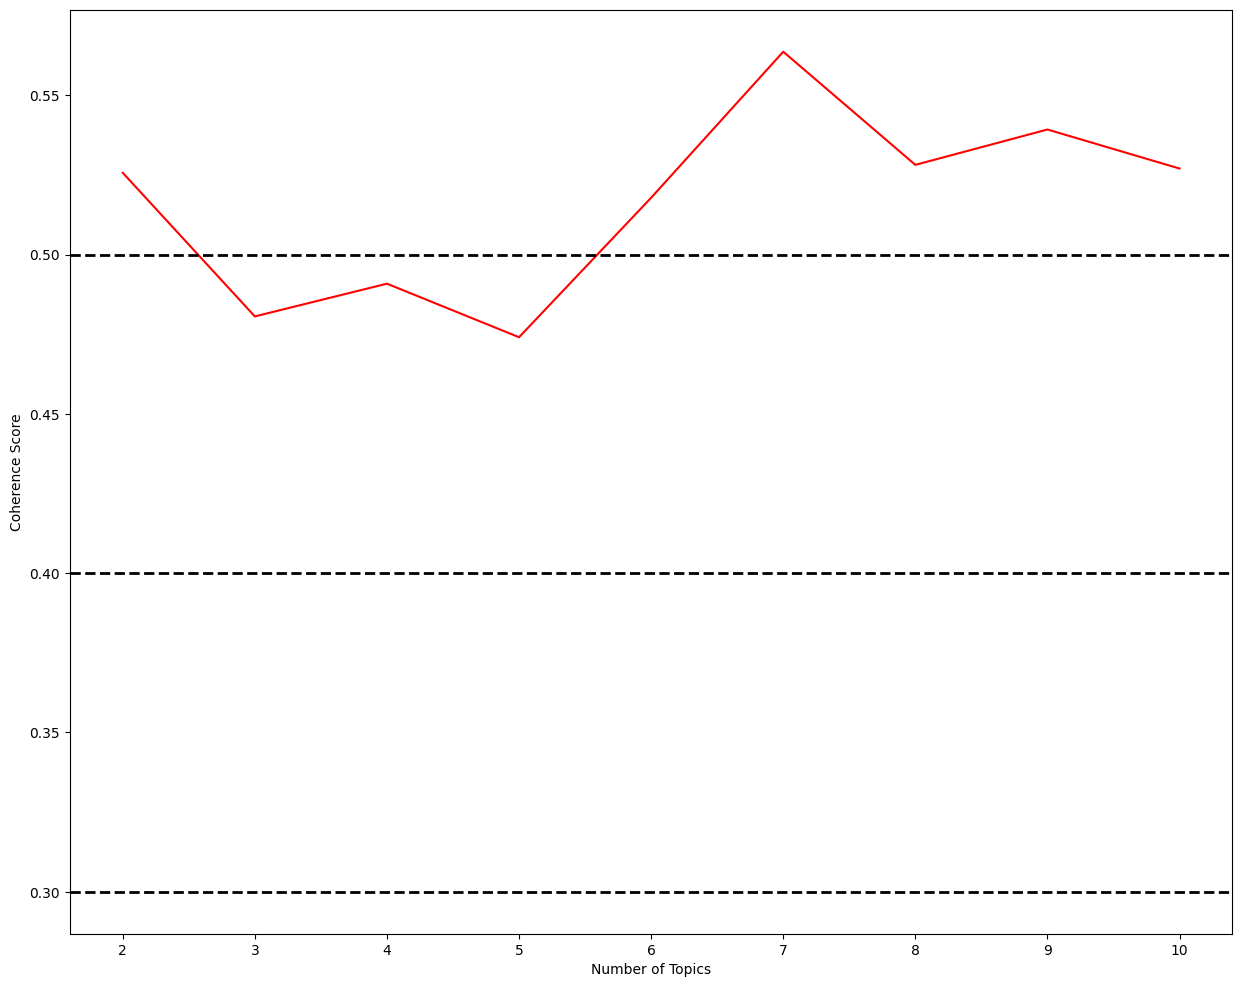

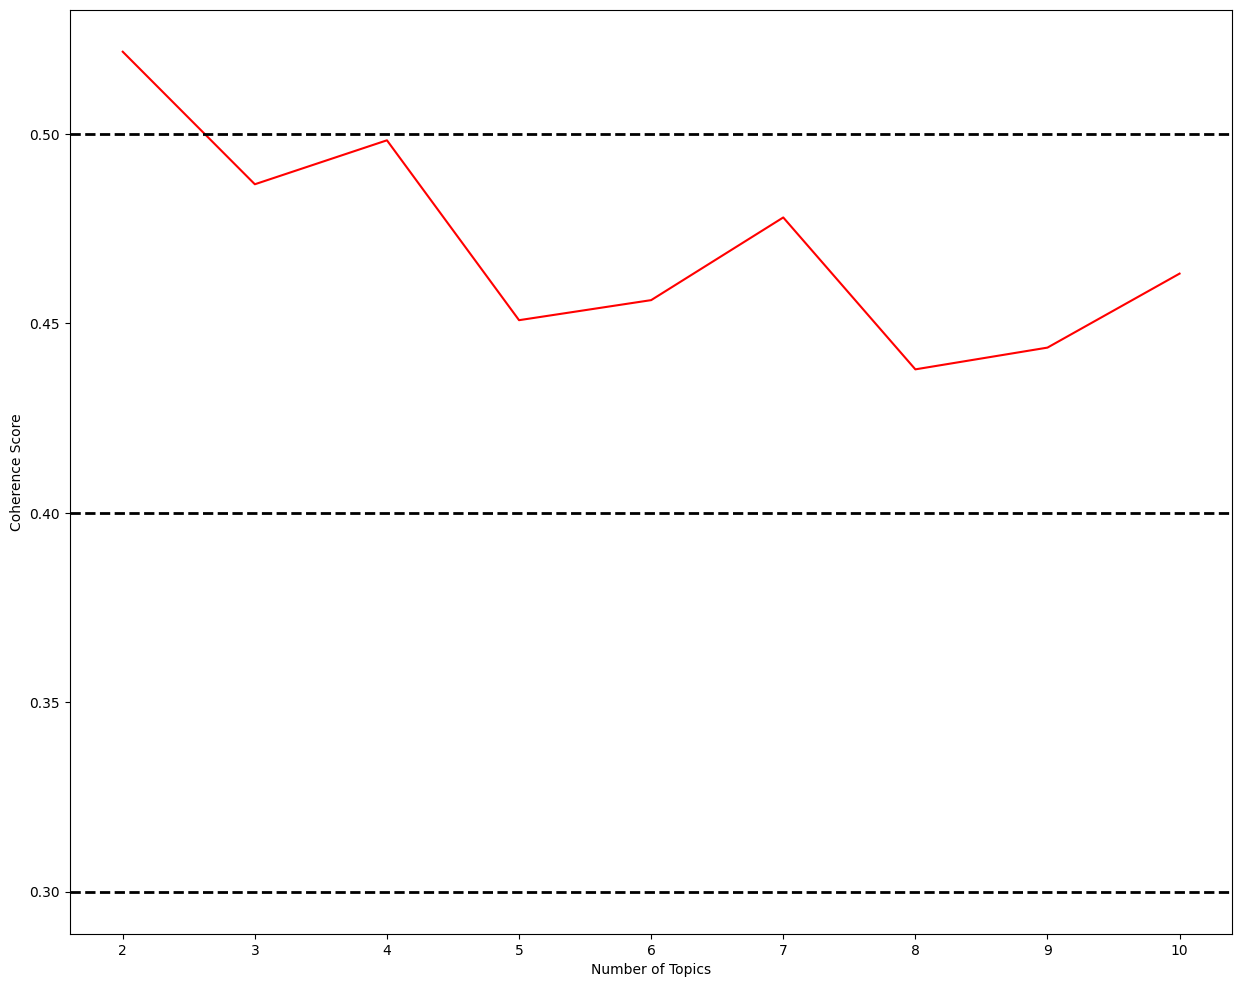

In [10]:
# Calculate coherence scores for each model
target_text = "review_cleaned_v2"

overall_coherence_df = pd.DataFrame() # df to store coherence_df
model_topic_info_list = []  # List to store model_topic_info

for i, df_set in enumerate(df_sets):
    
    print("\nDF NAME: {}\n".format(df_names[i]))

    coherence_df, model_topic_info = topic_model_coherence_plot(df_set, df_names[i], target_text, MODEL_NAMES, START_TOPIC_COUNT, END_TOPIC_COUNT)
    overall_coherence_df = pd.concat([overall_coherence_df, coherence_df], axis=0) # Concatenate to overall_coherence_df
    model_topic_info_list.append(model_topic_info) # Store model_topic_info in a list

In [11]:
# Print all models' coherence scores
overall_coherence_df

,Model Name,Number of Topics,Coherence Score,df_name
0,LSI,2,0.577735,df_pos
1,LSI,3,0.623735,df_pos
2,LSI,4,0.605971,df_pos
3,LSI,5,0.652938,df_pos
4,LSI,6,0.666641,df_pos
5,LSI,7,0.638846,df_pos
6,LSI,8,0.623324,df_pos
7,LSI,9,0.642361,df_pos
8,LSI,10,0.631352,df_pos
0,LDA,2,0.528904,df_pos


In [12]:
# Store coherence scores of all models into "overall_coherence_df", sort by "df_name" and "Coherence Score"
overall_coherence_df = overall_coherence_df.sort_values(["df_name", "Coherence Score"], ascending=False).reset_index(drop=True)
#overall_coherence_df

# Find best model for each df
overall_coherence_best_df = overall_coherence_df.loc[overall_coherence_df.groupby("df_name")["Coherence Score"].idxmax()].reset_index(drop=True)
overall_coherence_best_df

,Model Name,Number of Topics,Coherence Score,df_name
0,LSI,7,0.563722,df_neg
1,LSI,6,0.666641,df_pos


In [13]:
# Print topics of best model
print_best_model_topics(overall_coherence_best_df, model_topic_info_list)


DF NAME: df_neg
MODEL: LSI - NUMBER OF TOPICS: 7

Topic 1: staff, clean, check, small, good, even, breakfast, could, bathroom, toilet

Topic 2: staff, small, check, clean, bathroom, toilet, bed, bit, reception, shower

Topic 3: breakfast, clean, small, staff, book, could, toilet, restaurant, bad, pay

Topic 4: small, staff, clean, breakfast, good, well, could, pay, bathroom, bed

Topic 5: staff, check, good, breakfast, reception, clean, even, smell, also, ask

Topic 6: smell, clean, good, toilet, old, small, bad, guest, service, even

Topic 7: good, bad, breakfast, small, smell, even, give, price, reception, check

----------


DF NAME: df_pos
MODEL: LSI - NUMBER OF TOPICS: 6

Topic 1: good, staff, clean, great, nice, friendly, small, bed, also, check

Topic 2: good, staff, great, check, friendly, helpful, clean, nice, book, could

Topic 3: staff, clean, friendly, good, bed, also, helpful, small, water, near

Topic 4: clean, check, book, god, reception, could, nice, near, service, pro

In [14]:
end_time = datetime.now()
print("Text processing ended at {}".format(end_time))
print("Text processing spent {}".format(end_time - start_time))

Text processing ended at 2024-06-26 22:39:59.435727
Text processing spent 0:10:17.155428
